# Domain Adaptive Fine Tuning with custom domain corpus

Initialization - Set Runtime type as GPU

This Notebook is part of the final Thesis.

The pre-trained language models from the Transformer library are further fine-tuned with the domain data in this Notebook. The domain data corpus is created with the downloadable content from NCFE.ORG.

The following pre-trained models are fine-tuned with the domain data in this step. The models 4 to 6 are created from the previous step - domain adaptive fine-tuning with the FiQA dataset. The Perplexity of these models are measured after the fine-tuning. 

1. bert-base-uncased
2. roberta-base
3. finbert
4. bert-base-uncased-fiqa
5. roberta-base-fiqa
6. finbert-fiqa

In [1]:
# Make sure you have a GPU running
!nvidia-smi

Fri Dec 10 15:11:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers -q
!pip install datasets -q

     |████████████████████████████████| 3.3 MB 8.8 MB/s 
     |████████████████████████████████| 596 kB 54.5 MB/s 
     |████████████████████████████████| 61 kB 576 kB/s 
     |████████████████████████████████| 895 kB 61.6 MB/s 
     |████████████████████████████████| 3.3 MB 57.0 MB/s 
     |████████████████████████████████| 298 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 50.2 MB/s 
     |████████████████████████████████| 132 kB 70.1 MB/s 
     |████████████████████████████████| 243 kB 72.4 MB/s 
     |████████████████████████████████| 271 kB 73.8 MB/s 
     |████████████████████████████████| 160 kB 54.3 MB/s 
     |████████████████████████████████| 192 kB 62.4 MB/s 


In [4]:
import datasets
from datasets import load_dataset

In [5]:
import numpy as np
import pandas as pd
import regex as re
import os
import torch
import json
import sys
import time
import datetime
import random
import math
import collections
from pathlib import Path

In [52]:
# Utility Function - Show random elements
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [74]:
from datasets import load_dataset
dataset_dict = load_dataset('text', data_files='/content/drive/MyDrive/FinLitQA/ncfe_data.txt')
dataset = dataset_dict['train']
finlit_ds = dataset.train_test_split(test_size=0.2)
finlit_ds

Using custom data configuration default-908c862bfc7e209b
Reusing dataset text (/root/.cache/huggingface/datasets/text/default-908c862bfc7e209b/0.0.0/e16f44aa1b321ece1f87b07977cc5d70be93d69b20486d6dacd62e12cf25c9a5)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 4940
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1236
    })
})

# Masked Language Modeling using Huggingface

## Prepare Data for Training

In [46]:
# from datasets import load_dataset

# ncfe_data_path = '/content/drive/MyDrive/FinLitQA/NCFE_Content/ncfe_data.txt'
# ncfe_data_train_path = '/content/drive/MyDrive/FinLitQA/NCFE_Content/ncfe_data_train.txt'
# ncfe_data_valid_path = '/content/drive/MyDrive/FinLitQA/NCFE_Content/ncfe_data_valid.txt'

# finlit_data = load_dataset("text", data_files={"train": ncfe_data_train_path,
#                                              "validation": ncfe_data_valid_path})

# finlit_data, finlit_data.column_names

In [75]:
finlit_ds["train"]

Dataset({
    features: ['text'],
    num_rows: 4940
})

In [48]:
# finlit_ds.set_format("pandas")
# # Flatten the nested dataset columns for easy access
# dfs = {split:ds[:] for split, ds in finlit_ds.flatten().items()}

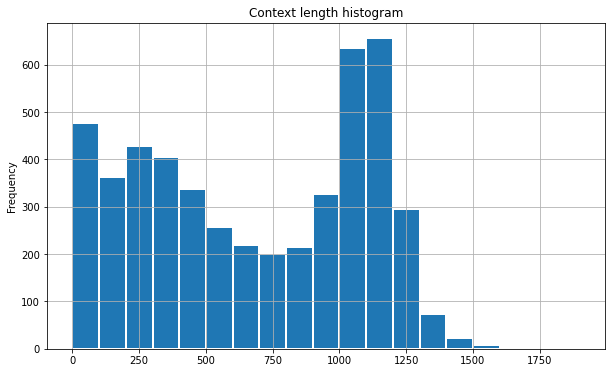

In [49]:
# figsize = (10,6)
# dfs['train']['text'].apply(len).plot.hist(title="Context length histogram", bins=range(0,2000,100), 
#                                           edgecolor='white', linewidth=2, figsize=figsize, grid=True)

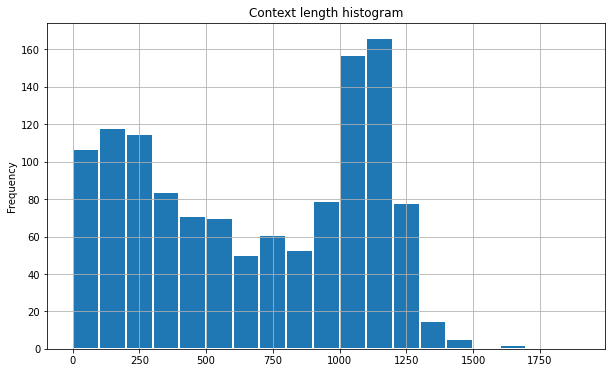

In [50]:
# figsize = (10,6)
# dfs['test']['text'].apply(len).plot.hist(title="Context length histogram", bins=range(0,2000,100), 
#                                           edgecolor='white', linewidth=2, figsize=figsize, grid=True)

In [53]:
# show_random_elements(finlit_ds["train"])

,text
0,"1563\tlook for mrs. bharati's explanation at the end of the section. advise me!!! gita has goals i just learnt about financial goal setting and want to give it a shot. 1 am a 21-year-old working in a call center for the last one year. i make good money (rs. 2.41 lakh p.a. ), and i wish to use it wisely. so i have set following goals for myself: 1. save for further education (2-4 years timeline). 2. invest in stock markets to help my money grow (immediate). 3. buy a house--my company gives home loans when i complete 5 years in the job. 4. fund a holiday to a nearby hill station. 5. repay credit card debt of rs. 25000. gita seems to have good intentions but is she getting it right? use the space below to write your understanding of gita's approach. look for mrs. bharati's explanation at the end of the section. mrs. bharati's common money sense answers dear ravi, you are one of those lucky people who does not have any responsibilities and have an opportunity to start building your wealth right away."
1,strategic financial planning
2,"727\tshe interacted regularly with the diplomat friend. the diplomat friend mentioned that he will soon be coming to india and will meet her at the embassy. he also mentioned that they are looking for promoting some people to the next level. a week later, sarita received an international call on her mobile from someone posing as the diplomat friend's wife. the caller informed sarita that her friend had travelled to india in connection with embassy work last week. on his way to india, he lost his passport and got arrested by indian police. the diplomat has been booked on criminal charges and the police is tracing all his friends and contacts. the caller also mentioned that sarita was in danger of being tracked by police and may be interrogated. the caller further mentioned that it is important that the diplomat be given adequate legal support so that all other friends of his can be spared from interrogation and possible arrest. since a lawyer would have to be hired in india and his fees would have to be paid immediately, the caller asked sarita to deposit `10 lakhs in a bank account to meet the expenses.\ttext\t{'_split_id': 727}"
3,"1372\t""financial service providers usually lend out the deposits they collect to earn interest and it is important that they do not take excessive risks or make irresponsible investments. why not invite the manager of a local financial institution to come and talk to you about how they manage their business? you can ask him how they are supervised and how they manage their lending decisions. acknowledgements the influence of stuart rutherford and his book """"the poor and their money"""" (oup 2000); the diagrams on pages 2 and 3 are based on his work. the staff of the fao project """"improving household food security and nutrition in the luapula valley of zambia"""" who were involved in developing the cash flow story. the weekly money management system on page 33 is based on the system developed by the trident institute of south africa for their one-up business training course. explaining profitability and borrowing rural infrastructure and agro-industries division food and agriculture organization of the united nations rome italy by jennifer heney all rights reserved."""
4,"create broad base holding pattern and depth provide efficient price discovery mechanism in primary and secondary market thereby strengthening the existing system diversification of risk low cost of intermediation for investors advantages of retailing through nse wide reach on account of nation-wide spread of nse trading network, with more than 800 active brokers spread across 380 cities. screen based, anonymous order driven system familiar to retail investors for over 8 years.""\ttext\t{'_split_id': 236}"


In [54]:
# show_random_elements(finlit_ds["test"])

,text
0,"155\t""classified as : primary markets and secondary markets"
1,risk-return hierarchy of different funds risk high sector funds diversified equity funds index funds balanced funds debt funds gilt funds risk low mmmf low return high return
2,"wave characteristic wave b prices reverse higher many see as a resumption of the now long-gone bull market right shoulder of a head and shoulders reversal pattern the volume during wave b should be lower than in wave a fundamentals are probably no longer improving, but they most likely have not yet turned negative wave c prices move impulsively lower in five waves volume picks up, and by the third leg of wave c, almost everyone realizes that a bear market is firmly entrenched wave c is typically at least as large as wave a and often extends to 1.618 times wave a or beyond"
3,"1667\t""deciding the payment option that suits you the best--through your/family's savings, sale of other property/ investments or with a housing loan. how much home loan to take, what type of interest, for what period of time and at what monthly installment? purchase transfer of ownership and related rights in your favour, checking the house for fulfillment of all the commitments by the seller. insurance -- considering house insurance. safe keeping of records--home loan documents, land registration with the corporation, house ownership documents, if it's a housing society then membership documents, house insurance papers. relevant financial channels--savings account, home loans, insurance"
4,"financial literacy risk management strategies common risk management strategies for individual investors are asset allocation and averaging. the averaging strategy was discussed in detail in an earlier chapter. in this chapter, we will look at asset allocation strategy. asset allocation asset allocation is a strategy that aims to balance risk versus reward by identifying right mix of various assets like fixed deposits, provident fund, etf's, equity mutual funds etc., in an investment portfolio according to investors risk appetite and risk capacity. asset allocation example 1 abhisek is currently 35 years of age. abhishek has accumulated rs.5 lakhs which he now wants to invest properly so that he can balance risk and rewards."""


## MLM - Chunking

In [76]:
# Current Directory 
%cd /content/drive/MyDrive/FinLitQA

# Create Directory to save the model
!mkdir model

/content/drive/MyDrive/FinLitQA
mkdir: cannot create directory ‘model’: File exists


In [77]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec 10 16:04:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    35W / 250W |   1593MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [78]:
# Define common functions: 
def chunk_examples(examples):
    chunks = []
    for sentence in examples['text']:
        chunks += [sentence[i:i + 500] for i in range(0, len(sentence), 500)]
    return {'chunks': chunks}

def tokenize_function(examples):
    return tokenizer(examples["chunks"])

In [79]:
# block_size = tokenizer.model_max_length

block_size = 128

In [80]:
def group_texts(examples, block_size=128):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
        # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [81]:
# Chunk the examples if the length is greater then 500

finlit_chunked = finlit_ds.map(chunk_examples, batched=True, remove_columns=["text"])

finlit_chunked, finlit_chunked['train'][:5]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

(DatasetDict({
    train: Dataset({
        features: ['chunks'],
        num_rows: 9599
    })
    test: Dataset({
        features: ['chunks'],
        num_rows: 2420
    })
}),
 {'chunks': ['primary market  deals with the issuance of new securities  process of selling new issues to investors is called underwriting  new stock issue is called initial public offering (ipo)  converts a ""pvt ltd"" firm to a ""public ltd"" firm',
   '312\tmanaging your personal finances well is the key to leading a secure life. you must always correctly estimate the amount of assets you can purchase, and also keep a check on your expenses. losing track of these and over-estimating your purchasing capacity, say by taking a loan, for which emi payments are more than what you can bear, could lead you into financial troubles. education loan acquisition of any type of asset requires money. if you do not have the entire quantum of funds required to',
   ' obtain the desired asset, you turn to financial institu

In [130]:
finlit_chunked.set_format("pandas")
# Flatten the nested dataset columns for easy access
dfs = {split:ds[:] for split, ds in finlit_chunked.flatten().items()}

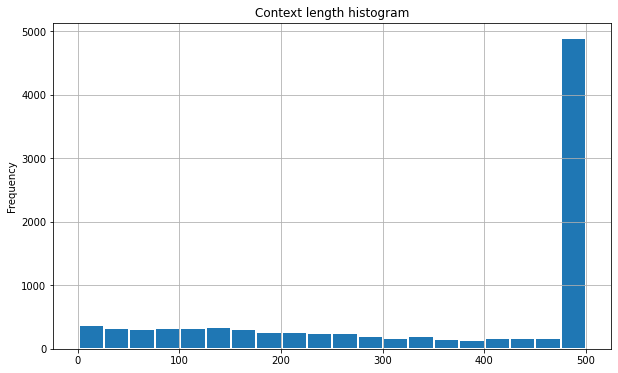

In [131]:
figsize = (10,6)
dfs['train']['chunks'].apply(len).plot.hist(title="Context length histogram", bins=20, 
                                          edgecolor='white', linewidth=2, figsize=figsize, grid=True)

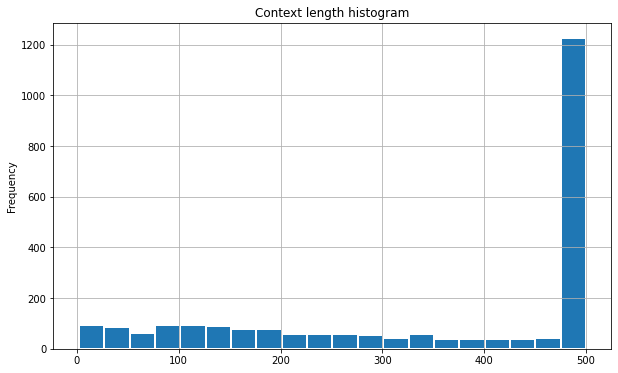

In [132]:
figsize = (10,6)
dfs['test']['chunks'].apply(len).plot.hist(title="Context length histogram", bins=20, 
                                          edgecolor='white', linewidth=2, figsize=figsize, grid=True)

# MLM Modeling - Different Models


In [85]:
# Import from Transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling

In [86]:
df_lmtrain_summary = pd.DataFrame()

def add_to_lmtrain_summary(df) :
    global df_lmtrain_summary 
    df_lmtrain_summary = df_lmtrain_summary.append(df,ignore_index=True)

In [87]:
def evaluate_trainer(trainer, model_name):

    # Here we initialize the nodes that perform evaluation
    eval_results = trainer.evaluate()
    print (eval_results)
    print (f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

    df = pd.DataFrame.from_dict(eval_results, orient="index")
    df.columns = [model_name]
    results_df = df.transpose().reset_index()
    results_df['Perplexity'] = f"{math.exp(eval_results['eval_loss']):.2f}"
    add_to_lmtrain_summary(results_df)
  
    return(results_df)

In [97]:
# Function to Define the trainer
def trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets):
    '''Get the training arguments and define a trainer'''
    
    training_args = TrainingArguments(
        f"{model_dir}{model_name}",
        evaluation_strategy = "steps",
        num_train_epochs=10,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=12, 
        learning_rate=2e-5,
        weight_decay=0.01, 
        seed=42,
        save_steps=500,
        eval_steps=500,
        load_best_model_at_end=True
    )

    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=lm_datasets["train"],
        eval_dataset=lm_datasets["test"],
        data_collator=data_collator,
        tokenizer=tokenizer
    )
    
    return trainer

## Model 1 - "bert-base-uncased"

In [89]:
# Define the model checkpoint and Tokenizer

model_checkpoint1 = "bert-base-uncased"

In [90]:
type(finlit_chunked['train']['chunks'][0])

str

In [91]:
# Define Tokenizer and Model

#Training Arguments - Pass training arguments and define trainer
model_dir='/content/drive/MyDrive/FinLitQA/model/flm/' 
model_n = model_checkpoint1.split("/")[-1] 
model_suffix = "-flm" 
model_name = f"{model_n}{model_suffix}"

print (model_dir, model_name)

from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint1)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint1)


/content/drive/MyDrive/FinLitQA/model/flm/ bert-base-uncased-flm


loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at /root/.cache/huggingface/transformers/534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f41b0a70b600ca6b880c8f3df6f3535cbc704371bdfa4
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a

In [92]:
# Create language modeling datasets
finlit_tokenized = finlit_chunked.map(tokenize_function, batched=True, num_proc=4, remove_columns=["chunks"])
lm_datasets = finlit_tokenized.map(group_texts, batched=True, batch_size=1000, num_proc=4)

# trainer is defined here 
trainer = trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [93]:
%%time
trainer.train()

# Evaluate and check Perplexity
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running training *****
  Num examples = 6099
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1910


Step,Training Loss,Validation Loss
500,2.384900,2.187863
1000,2.186400,2.102549
1500,2.093800,2.063801


***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-flm/checkpoint-500
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-flm/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-flm/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-flm/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-flm/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-flm/checkpoint-1000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-flm/checkpoint-1000/config.json
Model weights saved in /content/

Perplexity: 7.78
CPU times: user 8min 55s, sys: 10.2 s, total: 9min 5s
Wall time: 9min 20s


In [94]:
# Save the model

save_path_model1 = "/content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-flm/"
trainer.save_model(save_path_model1)

# Evaluate the trainer and consolidate the results
# Calculate and add Perplexity to the evaluation results

evaluate_trainer(trainer, model_name)

Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-flm/
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-flm/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-flm/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-flm/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-flm/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12


{'eval_loss': 2.0270180702209473, 'eval_runtime': 7.7529, 'eval_samples_per_second': 195.54, 'eval_steps_per_second': 16.381, 'epoch': 5.0}
Perplexity: 7.59


,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-flm,2.027018,7.7529,195.54,16.381,5.0,7.59


In [95]:
# Reload model and check
model = AutoModelForMaskedLM.from_pretrained(save_path_model1, local_files_only=True)
trainer.model = model.cuda()

# Evaluate and check
eval_results = trainer.evaluate()
eval_results, f"{math.exp(eval_results['eval_loss']):.2f}"

loading configuration file /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-flm/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-flm/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-flm/pytorch_model.bin
All model checkpoint weights were used w

({'epoch': 5.0,
  'eval_loss': 2.063056230545044,
  'eval_runtime': 7.7418,
  'eval_samples_per_second': 195.821,
  'eval_steps_per_second': 16.405},
 '7.87')

In [ ]:
df_lmtrain_summary

,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-flm,2.184357,3.7841,194.764,16.384,3.0,8.88


## Model 2 - "roberta-base"

In [96]:
# model_checkpoint2 

model_checkpoint2 = "roberta-base"

In [98]:
# Define Tokenizer and Model

#Training Arguments - Pass training arguments and define trainer
model_dir='/content/drive/MyDrive/FinLitQA/model/flm/' 
model_n = model_checkpoint2.split("/")[-1] 
model_suffix = "-flm" 
model_name = f"{model_n}{model_suffix}"

print (model_dir, model_name)

# Tokenizer is defined here
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint2, use_fast=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint2)

# Create language modeling datasets
finlit_tokenized = finlit_chunked.map(tokenize_function, batched=True, num_proc=4, remove_columns=["chunks"])

lm_datasets = finlit_tokenized.map(group_texts, batched=True, batch_size=1000, num_proc=4)

# trainer is defined here 
trainer = trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets)

/content/drive/MyDrive/FinLitQA/model/flm/ roberta-base-flm


Could not locate the tokenizer configuration file, will try to use the model config instead.
https://huggingface.co/roberta-base/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpaunyr57s


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
creating metadata file for /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hid

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
creating metadata file for /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
https://huggingface.co/roberta-base/resolve/main/merges.txt not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpo514849u


Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/merges.txt in cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
creating metadata file for /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
https://huggingface.co/roberta-base/resolve/main/tokenizer.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpxenk8krj


Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/tokenizer.json in cache at /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
creating metadata file for /root/.cache/huggingface/transformers/d53fc0fa09b8342651efd4073d75e19617b3e51287c2a535becda5808a8db287.fc9576039592f026ad76a1c231b89aee8668488c671dfbe6616bab2ed298d730
loading file https://huggingface.co/roberta-base/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/d3ccdbfeb9aaa747ef20432d4976c32ee3fa69663b379deb253ccfce2bb1fdc5.d67d6b367eb24ab43b08ad55e014cf254076934f71d832bbab9ad35644a375ab
loading file https://huggingface.co/roberta-base/resolve/main/merges.txt from cache at /root/.cache/huggingface/transformers/cafdecc90fcab17011e12ac813dd574b4b3fea39da6dd817813efa010262ff3f.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
loading file https://huggingface.co/roberta

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

storing https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
creating metadata file for /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
All model checkpoint weights were used when initializing RobertaForMaskedLM.

All the weights of RobertaForMaskedLM were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Robe

In [99]:
%%time
trainer.train()

# Evaluate and check Perplexity
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running training *****
  Num examples = 5750
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3600


Step,Training Loss,Validation Loss
500,2.127600,1.930451
1000,1.946300,1.801022
1500,1.826800,1.773836
2000,1.762400,1.714935
2500,1.712100,1.653764
3000,1.681500,1.691740
3500,1.658600,1.659812


***** Running Evaluation *****
  Num examples = 1442
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-flm/checkpoint-500
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-flm/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-flm/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-flm/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-flm/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1442
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-flm/checkpoint-1000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-flm/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/ro

Perplexity: 5.41
CPU times: user 18min 42s, sys: 24.9 s, total: 19min 7s
Wall time: 19min 45s


In [100]:
# Save the model

save_path_model2 = "/content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-flm/"
trainer.save_model(save_path_model2)

# Evaluate the trainer and consolidate the results
# Calculate and add Perplexity to the evaluation results

evaluate_trainer(trainer, model_name)

Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-flm/
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-flm/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-flm/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-flm/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-flm/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1442
  Batch size = 12


{'eval_loss': 1.6454335451126099, 'eval_runtime': 8.2811, 'eval_samples_per_second': 174.131, 'eval_steps_per_second': 14.612, 'epoch': 10.0}
Perplexity: 5.18


,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,roberta-base-flm,1.645434,8.2811,174.131,14.612,10.0,5.18


In [101]:
# Reload model and check
model = AutoModelForMaskedLM.from_pretrained(save_path_model2, local_files_only=True)
trainer.model = model.cuda()

# Evaluate and check
eval_results = trainer.evaluate()
eval_results, f"{math.exp(eval_results['eval_loss']):.2f}"

loading configuration file /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-flm/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-flm/",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-flm/pytorch_model.bin
All model checkpoint weights were used 

({'epoch': 10.0,
  'eval_loss': 1.684234380722046,
  'eval_runtime': 8.2468,
  'eval_samples_per_second': 174.855,
  'eval_steps_per_second': 14.672},
 '5.39')

In [102]:
df_lmtrain_summary

,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-flm,2.027018,7.7529,195.540,16.381,5.0,7.59
1,roberta-base-flm,1.645434,8.2811,174.131,14.612,10.0,5.18


## Model 3 - "ProsusAI/finbert"

In [103]:
# model_checkpoint3 

model_checkpoint3 = "ProsusAI/finbert"

In [104]:
# Define Tokenizer and Model

#Training Arguments - Pass training arguments and define trainer
model_dir='/content/drive/MyDrive/FinLitQA/model/flm/' 
model_n = model_checkpoint3.split("/")[-1] 
model_suffix = "-flm" 
model_name = f"{model_n}{model_suffix}"

print (model_dir, model_name)

# Tokenizer is defined here
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint3, use_fast=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint3)

# Create language modeling datasets
finlit_tokenized = finlit_chunked.map(tokenize_function, batched=True, num_proc=4, remove_columns=["chunks"])

lm_datasets = finlit_tokenized.map(group_texts, batched=True, batch_size=1000, num_proc=4)

# trainer is defined here 
trainer = trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets)

/content/drive/MyDrive/FinLitQA/model/flm/ finbert-flm


https://huggingface.co/ProsusAI/finbert/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpo77fo3w7


Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

storing https://huggingface.co/ProsusAI/finbert/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/e3709a60694f45adca209a405cc69ce2b5d47b1cae60696ed9a901426be8c43d.8b6dccc90d16201c6d7ab0f3c6cc38e74b5f2fe587f6efadc9fa71fc0a00c606
creating metadata file for /root/.cache/huggingface/transformers/e3709a60694f45adca209a405cc69ce2b5d47b1cae60696ed9a901426be8c43d.8b6dccc90d16201c6d7ab0f3c6cc38e74b5f2fe587f6efadc9fa71fc0a00c606
https://huggingface.co/ProsusAI/finbert/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpli4pfd_o


Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

storing https://huggingface.co/ProsusAI/finbert/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/2120f4f96b5830e5a91fe94d242471b0133b0976c8d6e081594ab837ac5f17bc.ef97278c578016c8bb785f15296476b12eae86423097fed78719d1c8197a3430
creating metadata file for /root/.cache/huggingface/transformers/2120f4f96b5830e5a91fe94d242471b0133b0976c8d6e081594ab837ac5f17bc.ef97278c578016c8bb785f15296476b12eae86423097fed78719d1c8197a3430
loading configuration file https://huggingface.co/ProsusAI/finbert/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/2120f4f96b5830e5a91fe94d242471b0133b0976c8d6e081594ab837ac5f17bc.ef97278c578016c8bb785f15296476b12eae86423097fed78719d1c8197a3430
Model config BertConfig {
  "_name_or_path": "ProsusAI/finbert",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob"

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

storing https://huggingface.co/ProsusAI/finbert/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/a5b1a5451c9cf1702eec1072ac325d4af10e675a654628eab453b8cba2c6b111.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
creating metadata file for /root/.cache/huggingface/transformers/a5b1a5451c9cf1702eec1072ac325d4af10e675a654628eab453b8cba2c6b111.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
https://huggingface.co/ProsusAI/finbert/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpq2bibrzc


Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

storing https://huggingface.co/ProsusAI/finbert/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/4c21e8896b03f68c2e028133cf579267c62aba9de03a704a0845704e58eefe9e.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
creating metadata file for /root/.cache/huggingface/transformers/4c21e8896b03f68c2e028133cf579267c62aba9de03a704a0845704e58eefe9e.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d
loading file https://huggingface.co/ProsusAI/finbert/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/a5b1a5451c9cf1702eec1072ac325d4af10e675a654628eab453b8cba2c6b111.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/ProsusAI/finbert/resolve/main/tokenizer.json from cache at None
loading file https://huggingface.co/ProsusAI/finbert/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/ProsusAI/finbert/resolve/main/special_token

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

storing https://huggingface.co/ProsusAI/finbert/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/b3ba5be9f12905cef8d1d18af435dfd568d75466fae4a117a4f20ed5faadd3e3.8764ec40d33a40810fe5d2c1e864945dcf7affafd797ed8ef1b71392bfcf8562
creating metadata file for /root/.cache/huggingface/transformers/b3ba5be9f12905cef8d1d18af435dfd568d75466fae4a117a4f20ed5faadd3e3.8764ec40d33a40810fe5d2c1e864945dcf7affafd797ed8ef1b71392bfcf8562
loading weights file https://huggingface.co/ProsusAI/finbert/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/b3ba5be9f12905cef8d1d18af435dfd568d75466fae4a117a4f20ed5faadd3e3.8764ec40d33a40810fe5d2c1e864945dcf7affafd797ed8ef1b71392bfcf8562
Some weights of the model checkpoint at ProsusAI/finbert were not used when initializing BertForMaskedLM: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with ano

In [105]:
%%time
trainer.train()

# Evaluate and check Perplexity
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running training *****
  Num examples = 6099
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3820


Step,Training Loss,Validation Loss
500,4.726200,3.739104
1000,3.499500,3.201966
1500,3.117400,2.962182
2000,2.943400,2.812574
2500,2.781600,2.712839
3000,2.703000,2.632875
3500,2.646300,2.600824


***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/finbert-flm/checkpoint-500
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-flm/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-flm/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-flm/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-flm/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/finbert-flm/checkpoint-1000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-flm/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-flm/checkpoint-1000/pytorch_m

Perplexity: 13.47
CPU times: user 17min 54s, sys: 21.8 s, total: 18min 16s
Wall time: 18min 49s


In [106]:
# Save the model

save_path_model3 = "/content/drive/MyDrive/FinLitQA/model/flm_final/finbert-flm/"
trainer.save_model(save_path_model3)

# Evaluate the trainer and consolidate the results
# Calculate and add Perplexity to the evaluation results

evaluate_trainer(trainer, model_name)

Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-flm/
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-flm/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-flm/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-flm/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-flm/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12


{'eval_loss': 2.6298816204071045, 'eval_runtime': 7.7525, 'eval_samples_per_second': 195.551, 'eval_steps_per_second': 16.382, 'epoch': 10.0}
Perplexity: 13.87


,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,finbert-flm,2.629882,7.7525,195.551,16.382,10.0,13.87


In [107]:
# Reload model and check
model = AutoModelForMaskedLM.from_pretrained(save_path_model3, local_files_only=True)
trainer.model = model.cuda()

# Evaluate and check
eval_results = trainer.evaluate()
eval_results, f"{math.exp(eval_results['eval_loss']):.2f}"

loading configuration file /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-flm/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/flm_final/finbert-flm/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading wei

({'epoch': 10.0,
  'eval_loss': 2.5914196968078613,
  'eval_runtime': 7.751,
  'eval_samples_per_second': 195.588,
  'eval_steps_per_second': 16.385},
 '13.35')

In [108]:
df_lmtrain_summary

,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-flm,2.027018,7.7529,195.540,16.381,5.0,7.59
1,roberta-base-flm,1.645434,8.2811,174.131,14.612,10.0,5.18
2,finbert-flm,2.629882,7.7525,195.551,16.382,10.0,13.87


## Model 4 - "bert-base-uncased-fiqa"

In [109]:
# model_checkpoint4

model_checkpoint4 = "/content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/"

In [110]:
# Define Tokenizer and Model

#Training Arguments - Pass training arguments and define trainer
model_dir='/content/drive/MyDrive/FinLitQA/model/flm/' 
model_n = model_checkpoint4.split("/")[-2] 

print (f"{model_n}")
model_suffix = "-flm" 
model_name = f"{model_n}{model_suffix}"

print (model_dir, model_name)

bert-base-uncased-fiqa
/content/drive/MyDrive/FinLitQA/model/flm/ bert-base-uncased-fiqa-flm


In [111]:
# Tokenizer is defined here
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint4, local_files_only=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint4, local_files_only=True)

# Create language modeling datasets
finlit_tokenized = finlit_chunked.map(tokenize_function, batched=True, num_proc=4, remove_columns=["chunks"])

lm_datasets = finlit_tokenized.map(group_texts, batched=True, batch_size=1000, num_proc=4)

# trainer is defined here 
trainer = trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets)

Didn't find file /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/added_tokens.json. We won't load it.
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/vocab.txt
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/tokenizer.json
loading file None
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/special_tokens_map.json
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/tokenizer_config.json
loading configuration file /content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/fiqa_final/bert-base-uncased-fiqa/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidd

In [112]:
%%time
trainer.train()

# Evaluate and check Perplexity
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running training *****
  Num examples = 6099
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3820


Step,Training Loss,Validation Loss
500,2.192000,2.047057
1000,2.038500,1.962423
1500,1.940400,1.913403
2000,1.906000,1.879639
2500,1.830800,1.826792
3000,1.798900,1.818291
3500,1.768700,1.794163


***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-fiqa-flm/checkpoint-500
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-fiqa-flm/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-fiqa-flm/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-fiqa-flm/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-fiqa-flm/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-fiqa-flm/checkpoint-1000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/bert-base-uncased-fiqa-flm/checkpoint-1000/config.js

Perplexity: 6.14
CPU times: user 17min 54s, sys: 22.1 s, total: 18min 16s
Wall time: 18min 49s


In [113]:
# Save the model

save_path_model4 = "/content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-fiqa-flm/"
trainer.save_model(save_path_model4)

# Evaluate the trainer and consolidate the results
# Calculate and add Perplexity to the evaluation results

evaluate_trainer(trainer, model_name)

Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-fiqa-flm/
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-fiqa-flm/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-fiqa-flm/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-fiqa-flm/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-fiqa-flm/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12


{'eval_loss': 1.8241761922836304, 'eval_runtime': 7.7642, 'eval_samples_per_second': 195.256, 'eval_steps_per_second': 16.357, 'epoch': 10.0}
Perplexity: 6.20


,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-fiqa-flm,1.824176,7.7642,195.256,16.357,10.0,6.20


In [114]:
# Reload model and check
model = AutoModelForMaskedLM.from_pretrained(save_path_model4, local_files_only=True)
trainer.model = model.cuda()

# Evaluate and check
eval_results = trainer.evaluate()
eval_results, f"{math.exp(eval_results['eval_loss']):.2f}"

loading configuration file /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-fiqa-flm/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-fiqa-flm/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /content/drive/MyDrive/FinLitQA/model/flm_final/bert-base-uncased-fiqa-flm/pytorch_model.bin
All model checkpoint weig

({'epoch': 10.0,
  'eval_loss': 1.775473713874817,
  'eval_runtime': 7.7618,
  'eval_samples_per_second': 195.315,
  'eval_steps_per_second': 16.362},
 '5.90')

In [115]:
df_lmtrain_summary

,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-flm,2.027018,7.7529,195.540,16.381,5.0,7.59
1,roberta-base-flm,1.645434,8.2811,174.131,14.612,10.0,5.18
2,finbert-flm,2.629882,7.7525,195.551,16.382,10.0,13.87
3,bert-base-uncased-fiqa-flm,1.824176,7.7642,195.256,16.357,10.0,6.20


## Model 5 - "roberta-base-fiqa"

In [116]:
# model_checkpoint5

model_checkpoint5 = "/content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/"

In [117]:
# Define Tokenizer and Model

#Training Arguments - Pass training arguments and define trainer
model_dir='/content/drive/MyDrive/FinLitQA/model/flm/' 
model_n = model_checkpoint5.split("/")[-2] 
model_suffix = "-flm" 
model_name = f"{model_n}{model_suffix}"

print (model_dir, model_name)

/content/drive/MyDrive/FinLitQA/model/flm/ roberta-base-fiqa-flm


In [118]:
# Tokenizer is defined here
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint5, local_files_only=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint5, local_files_only=True)

# Create language modeling datasets
finlit_tokenized = finlit_chunked.map(tokenize_function, batched=True, num_proc=4, remove_columns=["chunks"])

lm_datasets = finlit_tokenized.map(group_texts, batched=True, batch_size=1000, num_proc=4)

# trainer is defined here 
trainer = trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets)

Didn't find file /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/added_tokens.json. We won't load it.
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/vocab.json
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/merges.txt
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/tokenizer.json
loading file None
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/special_tokens_map.json
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/tokenizer_config.json
loading configuration file /content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/fiqa_final/roberta-base-fiqa/",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token

In [119]:
%%time
trainer.train()

# Evaluate and check Perplexity
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running training *****
  Num examples = 5750
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3600


Step,Training Loss,Validation Loss
500,2.050500,1.884697
1000,1.904100,1.763495
1500,1.790400,1.743682
2000,1.729600,1.687358
2500,1.682700,1.627961
3000,1.652200,1.666716
3500,1.631400,1.634170


***** Running Evaluation *****
  Num examples = 1442
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-fiqa-flm/checkpoint-500
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-fiqa-flm/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-fiqa-flm/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-fiqa-flm/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-fiqa-flm/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1442
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-fiqa-flm/checkpoint-1000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/roberta-base-fiqa-flm/checkpoint-1000/config.json
Model weights saved in /content/

Perplexity: 5.24
CPU times: user 18min 42s, sys: 25.5 s, total: 19min 7s
Wall time: 19min 45s


In [120]:
# Save the model

save_path_model5 = "/content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-fiqa-flm/"
trainer.save_model(save_path_model5)

# Evaluate the trainer and consolidate the results
# Calculate and add Perplexity to the evaluation results

evaluate_trainer(trainer, model_name)

Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-fiqa-flm/
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-fiqa-flm/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-fiqa-flm/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-fiqa-flm/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-fiqa-flm/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1442
  Batch size = 12


{'eval_loss': 1.6144648790359497, 'eval_runtime': 8.277, 'eval_samples_per_second': 174.218, 'eval_steps_per_second': 14.619, 'epoch': 10.0}
Perplexity: 5.03


,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,roberta-base-fiqa-flm,1.614465,8.277,174.218,14.619,10.0,5.03


In [121]:
# Reload model and check
model = AutoModelForMaskedLM.from_pretrained(save_path_model5, local_files_only=True)
trainer.model = model.cuda()

# Evaluate and check
eval_results = trainer.evaluate()
eval_results, f"{math.exp(eval_results['eval_loss']):.2f}"

loading configuration file /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-fiqa-flm/config.json
Model config RobertaConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-fiqa-flm/",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file /content/drive/MyDrive/FinLitQA/model/flm_final/roberta-base-fiqa-flm/pytorch_model.bin
All model checkpoint wei

({'epoch': 10.0,
  'eval_loss': 1.6568320989608765,
  'eval_runtime': 8.2617,
  'eval_samples_per_second': 174.541,
  'eval_steps_per_second': 14.646},
 '5.24')

In [122]:
df_lmtrain_summary

,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-flm,2.027018,7.7529,195.540,16.381,5.0,7.59
1,roberta-base-flm,1.645434,8.2811,174.131,14.612,10.0,5.18
2,finbert-flm,2.629882,7.7525,195.551,16.382,10.0,13.87
3,bert-base-uncased-fiqa-flm,1.824176,7.7642,195.256,16.357,10.0,6.20
4,roberta-base-fiqa-flm,1.614465,8.2770,174.218,14.619,10.0,5.03


## Model 6 - "finbert-fiqa"

In [123]:
# model_checkpoint6

model_checkpoint6 = "/content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/"

In [124]:
# Define Tokenizer and Model

#Training Arguments - Pass training arguments and define trainer
model_dir='/content/drive/MyDrive/FinLitQA/model/flm/' 
model_n = model_checkpoint6.split("/")[-2] 
model_suffix = "-flm" 
model_name = f"{model_n}{model_suffix}"

print (model_dir, model_name)

/content/drive/MyDrive/FinLitQA/model/flm/ finbert-fiqa-flm


In [125]:
# Tokenizer is defined here
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint6, local_files_only=True)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint6, local_files_only=True)

# Create language modeling datasets
finlit_tokenized = finlit_chunked.map(tokenize_function, batched=True, num_proc=4, remove_columns=["chunks"])

lm_datasets = finlit_tokenized.map(group_texts, batched=True, batch_size=1000, num_proc=4)

# trainer is defined here 
trainer = trainer_from_args(model_dir, model_name, model, tokenizer, lm_datasets)

Didn't find file /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/added_tokens.json. We won't load it.
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/vocab.txt
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/tokenizer.json
loading file None
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/special_tokens_map.json
loading file /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/tokenizer_config.json
loading configuration file /content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/fiqa_final/finbert-fiqa/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative

In [126]:
%%time
trainer.train()

# Evaluate and check Perplexity
eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

***** Running training *****
  Num examples = 6099
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3820


Step,Training Loss,Validation Loss
500,2.742700,2.528950
1000,2.529700,2.407656
1500,2.390600,2.327312
2000,2.343600,2.273634
2500,2.250100,2.224309
3000,2.213400,2.196584


***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-500
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-1000
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/fi

Step,Training Loss,Validation Loss
500,2.742700,2.528950
1000,2.529700,2.407656
1500,2.390600,2.327312
2000,2.343600,2.273634
2500,2.250100,2.224309
3000,2.213400,2.196584
3500,2.183500,2.162918


***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12
Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-3500
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-3500/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-3500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-3500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-3500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/drive/MyDrive/FinLitQA/model/flm/finbert-fiqa-flm/checkpoint-3500 (score: 2.1629178524017334).
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12


Perplexity: 8.81
CPU times: user 17min 53s, sys: 21.4 s, total: 18min 15s
Wall time: 18min 48s


In [127]:
# Save the model

save_path_model6 = "/content/drive/MyDrive/FinLitQA/model/flm_final/finbert-fiqa-flm/"
trainer.save_model(save_path_model6)

# Evaluate the trainer and consolidate the results
# Calculate and add Perplexity to the evaluation results

evaluate_trainer(trainer, model_name)

Saving model checkpoint to /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-fiqa-flm/
Configuration saved in /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-fiqa-flm/config.json
Model weights saved in /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-fiqa-flm/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-fiqa-flm/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-fiqa-flm/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1516
  Batch size = 12


{'eval_loss': 2.194920778274536, 'eval_runtime': 7.7568, 'eval_samples_per_second': 195.44, 'eval_steps_per_second': 16.373, 'epoch': 10.0}
Perplexity: 8.98


,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,finbert-fiqa-flm,2.194921,7.7568,195.44,16.373,10.0,8.98


In [128]:
# Reload model and check
model = AutoModelForMaskedLM.from_pretrained(save_path_model6, local_files_only=True)
trainer.model = model.cuda()

# Evaluate and check
eval_results = trainer.evaluate()
eval_results, f"{math.exp(eval_results['eval_loss']):.2f}"

loading configuration file /content/drive/MyDrive/FinLitQA/model/flm_final/finbert-fiqa-flm/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/FinLitQA/model/flm_final/finbert-fiqa-flm/",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "positive",
    "1": "negative",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 1,
    "neutral": 2,
    "positive": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

l

({'epoch': 10.0,
  'eval_loss': 2.1579673290252686,
  'eval_runtime': 7.7459,
  'eval_samples_per_second': 195.716,
  'eval_steps_per_second': 16.396},
 '8.65')

In [129]:
df_lmtrain_summary

,index,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,Perplexity
0,bert-base-uncased-flm,2.027018,7.7529,195.540,16.381,5.0,7.59
1,roberta-base-flm,1.645434,8.2811,174.131,14.612,10.0,5.18
2,finbert-flm,2.629882,7.7525,195.551,16.382,10.0,13.87
3,bert-base-uncased-fiqa-flm,1.824176,7.7642,195.256,16.357,10.0,6.20
4,roberta-base-fiqa-flm,1.614465,8.2770,174.218,14.619,10.0,5.03
5,finbert-fiqa-flm,2.194921,7.7568,195.440,16.373,10.0,8.98
